This Jupyter Notebook explores and processes popular deep learning datasets using PyTorch and torchvision. The datasets used in this project include:

MNIST – Handwritten digit images (0-9)

FashionMNIST – Grayscale fashion product images

CIFAR-10 – Color images of 10 object categories

Features of this Notebook:
✅ Dataset Loading – Uses torchvision.datasets to fetch datasets
✅ Data Preprocessing – Converts images into tensors and applies transformations
✅ Visualization – Displays sample images with corresponding labels
✅ Helper Functions – Custom utilities for dataset comparison and analysis
✅ PyTorch Version Checks – Ensures compatibility with minimum required versions

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/DL/')

import glob

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 best_model  'Colab Notebooks'	 helpers.py   __pycache__   testing.py	 utils_.py


In [ ]:
# Import PyTorch and related libraries
import torch
from torch.utils.data import Dataset, DataLoader

# Import torchvision and related libraries
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Import other libraries
import random
import os
from PIL import Image
import numpy as np
import pathlib
from typing import Tuple, Dict, List

# Import helper functions.
from helpers import compare_images, download_caltech_data, visualize_caltech_dataset

# Check versions
assert torch.__version__ >= "1.10.0", "PyTorch version must be at least 1.10.0"
assert torchvision.__version__ >= "0.11", "torchvision version must be at least 0.11"
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


## Load Datasets

We are going to load the *train* split of **3 datasets** from [`torchvision.datasets`](https://pytorch.org/vision/main/datasets.html), namely:
* `MNIST`: A collection of handwritten digits ranging from the number $0$ to $9$
* `FashionMNIST`: A dataset comprising of $28\times28$ grayscale images of fashion products from different categories
* `CIFAR-10`: A dataset containing $32\times32$ color images from $10$ different classes representing airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks

In [ ]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
fmnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

mnist_train_len = len(mnist_train)
fmnist_train_len = len(fmnist_train)
cifar10_train_len = len(cifar10_train)

mnist_classes = mnist_train.classes
fmnist_classes = fmnist_train.classes
cifar10_classes = cifar10_train.classes

Files already downloaded and verified


In [ ]:
print(f"MNIST Dataset:\nTrain size: {mnist_train_len} samples\nClasses: {mnist_classes}")
print('-' * 50)
print(f"FashionMNIST Dataset:\nTrain size: {fmnist_train_len} samples\nClasses: {fmnist_classes}")
print('-' * 50)
print(f"CIFAR-10 Dataset:\nTrain size: {cifar10_train_len} samples\nClasses: {cifar10_classes}")

MNIST Dataset:
Train size: 60000 samples
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
--------------------------------------------------
FashionMNIST Dataset:
Train size: 60000 samples
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
--------------------------------------------------
CIFAR-10 Dataset:
Train size: 50000 samples
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Data Visualization

In [ ]:
def visualize(dataset: torch.utils.data.Dataset, dataset_name: str, class_names: list, items: int=16):
    """
    Visualize a random sample of images from the given dataset.

    Args:
        dataset (torch.utils.data.Dataset): the dataset containing the images.
        dataset_name (str): the name of the dataset.
        class_names (list): The list of class names corresponding to the labels
        items (int): The number of items to visualize. Default
    Returns:
        None
    """
    torch.manual_seed(0)
    fig  = plt.figure(figsize=(15, 4))
    rows = 2
    cols = items // rows

    for i in range(1, items + 1):

        random_idx = torch.randint(low=0, high=len(dataset), size=(1,)).item()
        img, label = dataset[random_idx]

        fig.add_subplot(rows, cols, i)

        if img.size(0) == 1:
            plt.imshow(img.squeeze(), cmap='gray')
        else:
            plt.imshow(img.permute(1, 2, 0))  # change dims to HWC

        plt.title(f"Class:{class_names[label]}\nShape:{list(img.shape)}", fontsize=8)
        plt.axis('off')

    plt.suptitle(dataset_name, fontweight="bold")
    plt.tight_layout()
    plt.show()

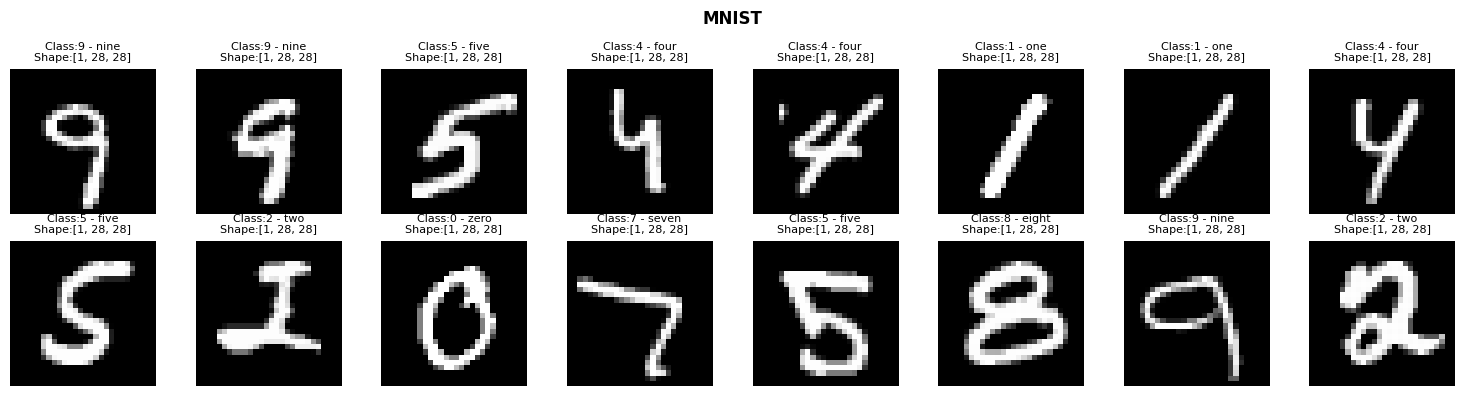

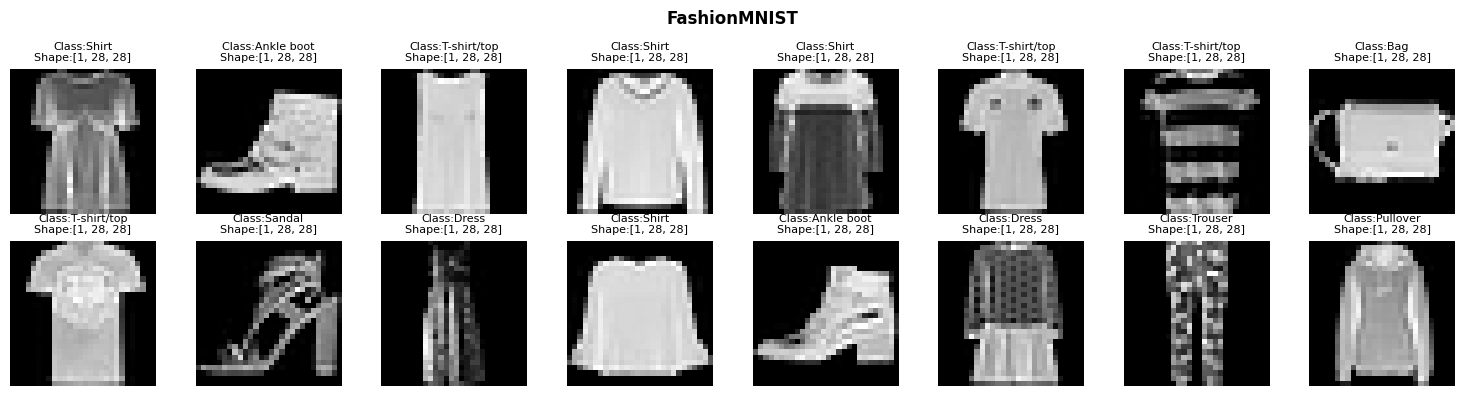

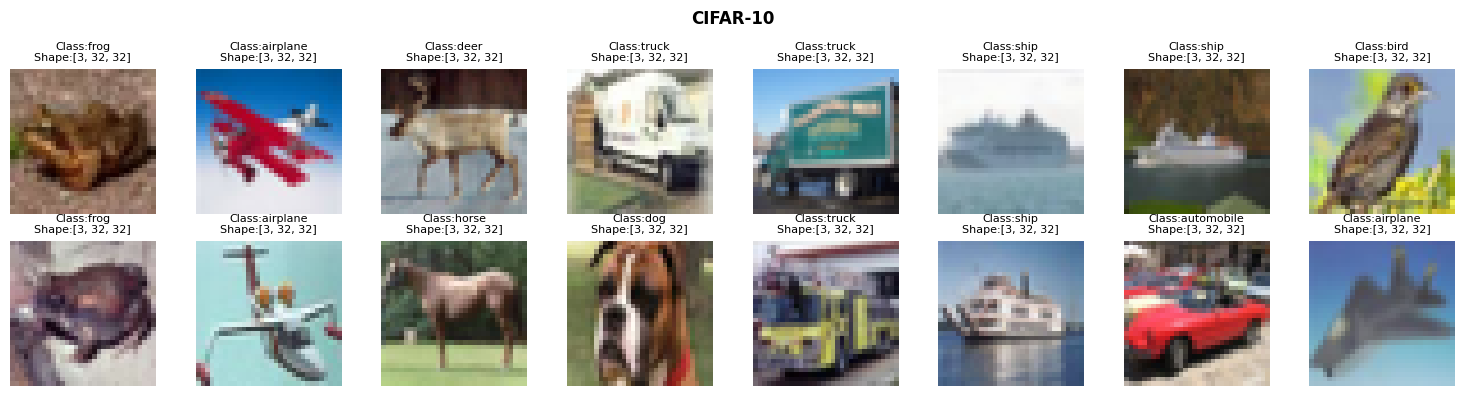

In [ ]:
# Iterate over each dataset and its corresponding classes
dataset_list = [(mnist_train, mnist_classes), (fmnist_train, fmnist_classes), (cifar10_train, cifar10_classes)]
dataset_names = ["MNIST", "FashionMNIST", "CIFAR-10"]
for name, (dataset, classes) in zip(dataset_names, dataset_list):
    # Call the visualize function to visualize a random sample of images from the dataset
    visualize(dataset, name, classes)

## Data Transformation and Augmentation
Common data transformation techniques:

| Technique              | Description                                                                                                                                                       |
|------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Normalization**      | This process scales the pixel values of images to a standard range, typically [0, 1] or [-1, 1]. Normalization helps in faster convergence during training and can improve model performance. |
| **Rescaling**          | Rescaling adjusts the size of the images to a fixed dimension, which is necessary for feeding images into a neural network.                                        |
| **Centering**          | This involves subtracting the mean of the dataset from each image, which helps in reducing the bias in the data.                                                   |
| **Standardization**    | This technique scales the data to have a mean of zero and a standard deviation of one. It is particularly useful when the features have different units or scales.  |
| **Data Augmentation**  | This includes techniques like random cropping, flipping, rotation, and color jittering to artificially increase the size of the training dataset and improve the model's generalization. |
| **Grayscale Conversion** | Converting RGB images to grayscale can be useful for certain tasks where color information is not important.                                                      |
| **Tensor Conversion**  | Converting images to tensors is necessary for processing them with deep learning frameworks like PyTorch.                                                          |


**Note:** For this section we are going to perform a subset of these transformations on `CIFAR-10` dataset due to its `RGB` format.

###Rescaling
**Rescaling (resizing)** a given input image from size [3, 32, 32] to **size [3, 16, 16]** using [`torchvision.transforms.Resize()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) method.

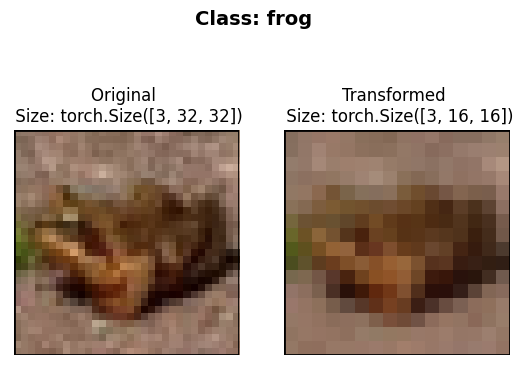

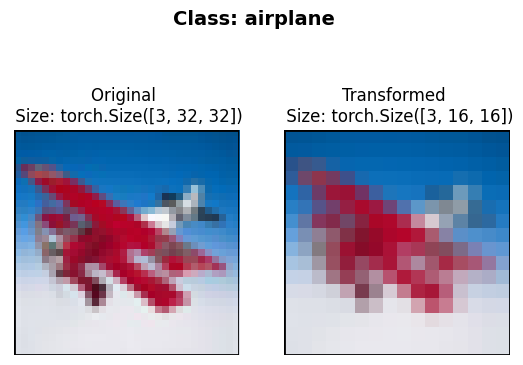

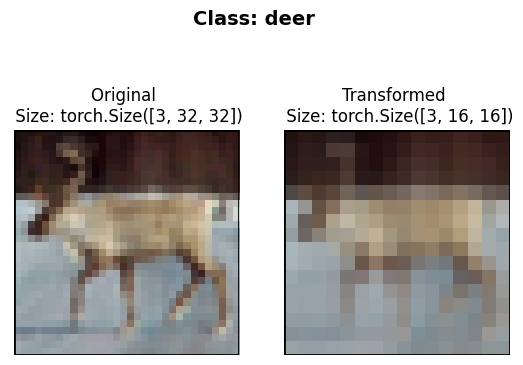

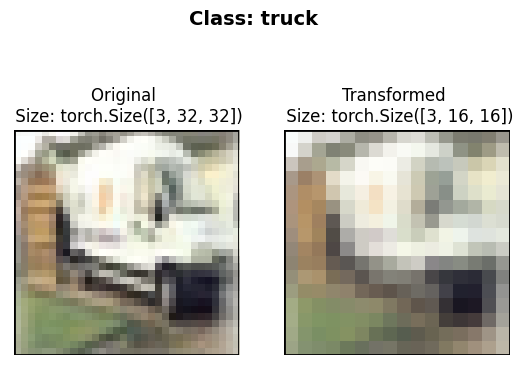

In [ ]:
resize = transforms.Compose([
    transforms.Resize((16, 16)),
])

compare_images(cifar10_train, resize, cifar10_classes)

### Grayscale Conversion
Next, we will convert the RGB channels to a **single channel (e.g., grayscaling)** using [`torchvision.transforms.Grayscale()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Grayscale.html) method.

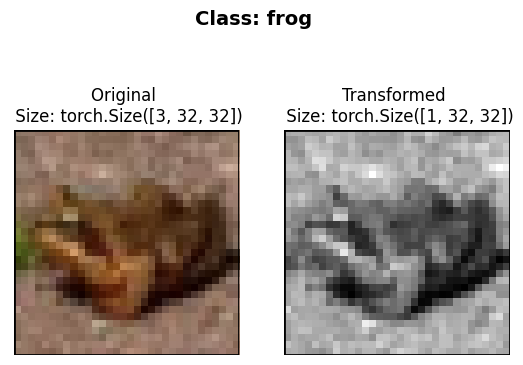

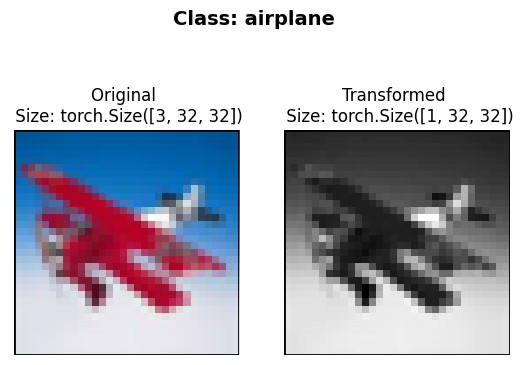

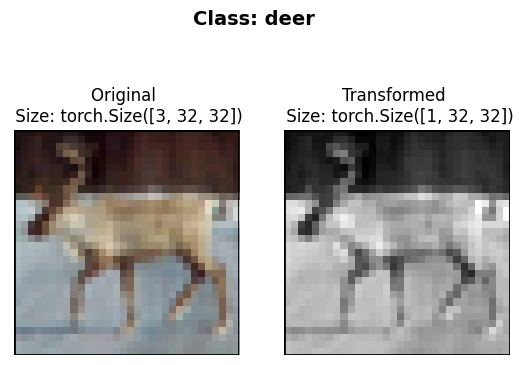

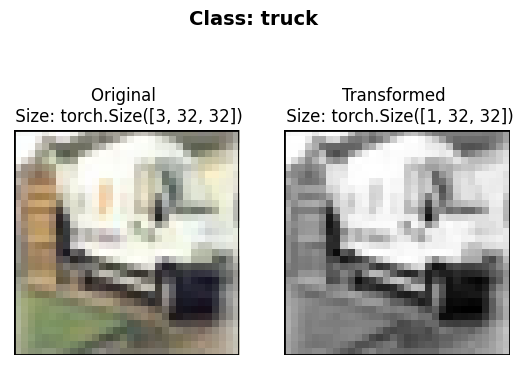

In [ ]:
grayscale = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
])

compare_images(cifar10_train, grayscale, cifar10_classes)

### Normalization
#### Z-Score Normalization
Now we will perform **Z-Score Normalization** using [`torchvision.transforms.Normalize()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html). <br>
This involves calculating the *mean* and *standard deviation* of each channel and subtracting these values from individual pixels of the corresponding channel that is:
$$
I_{i,j,k} = \frac{I_{i,j,k}-\mu_{k}}{\sigma_{k}}
$$
where, $I$ is the image, $k$ is the channel number and $i$, $j$ are the pixels (rows and columns) of the corresponding channel. Here $\mu_k$ and $\sigma_k$ are mean and std deviation of channel $k$.


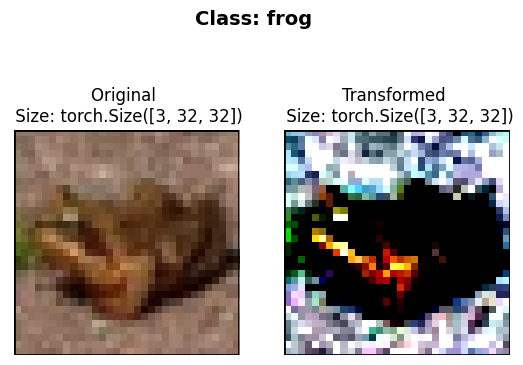

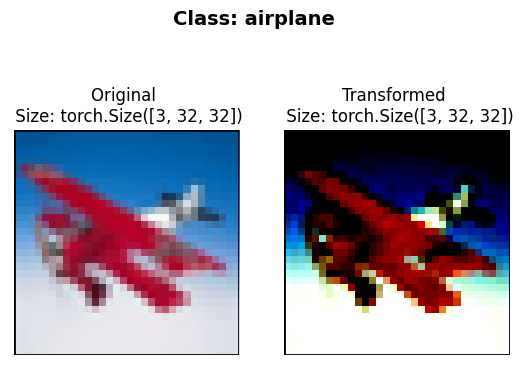

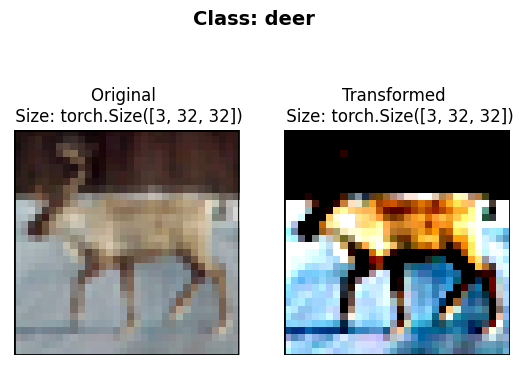

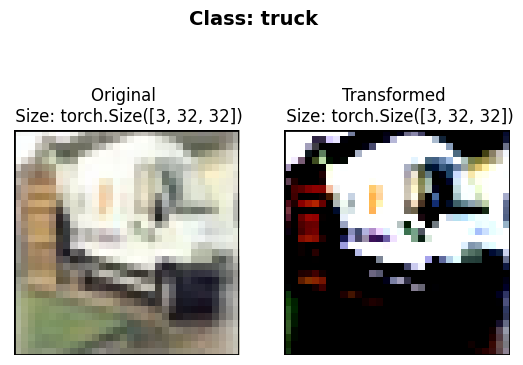

In [ ]:
def z_normalization(image: torch.Tensor) -> torch.Tensor:
    """
    Normalize the image using Z-score normalization.

    Args:
        image (torch.Tensor): The input image tensor.
    Returns:
        torch.Tensor: The z-score normalized image tensor.
    """

    means = image.mean(dim=[1, 2], keepdim=True)
    stds = image.std(dim=[1, 2], keepdim=True)

    z_transform = transforms.Normalize(mean=means.squeeze().tolist(), std=stds.squeeze().tolist())
    normalized_image = z_transform(image)

    return normalized_image

# note: expect truncation warning!
compare_images(cifar10_train, z_normalization, cifar10_classes)

#### Min/Max Normalization
Here we will perform Min/Max normalization using the following equation.<br> This involves calculating the min and max values of each channel and applying the following formula on each pixel of the corresponding channel:
$$
I_{i,j,k} = \frac{I_{i,j,k} - I_{k_{\text{min}}}}{I_{k_{\text{max}}} - I_{k_{\text{min}}}}
$$
where $I_{k_{\text{min}}}$ and $I_{k_{\text{max}}}$ are the *minimum* and *maximum* values of channel $k$ respectively.

> **Note**: *We are not using any torchvision.transform method here.*

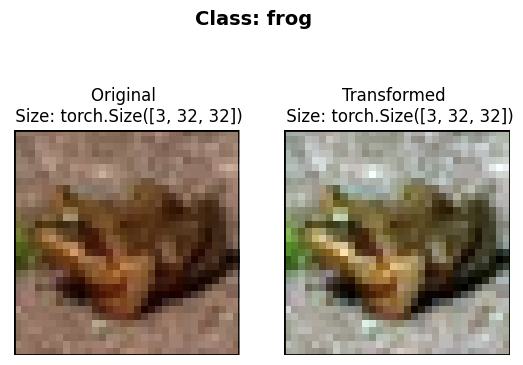

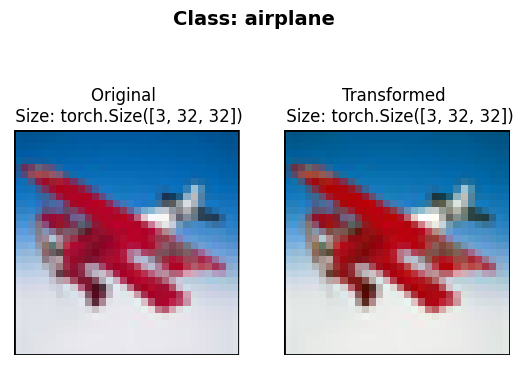

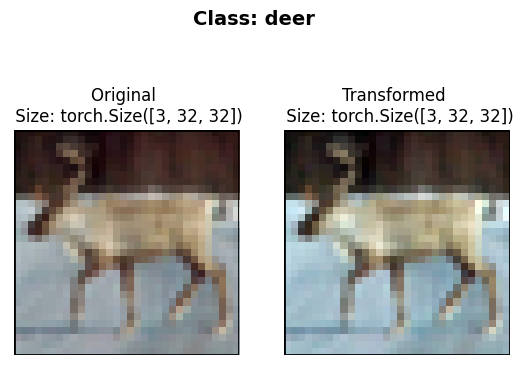

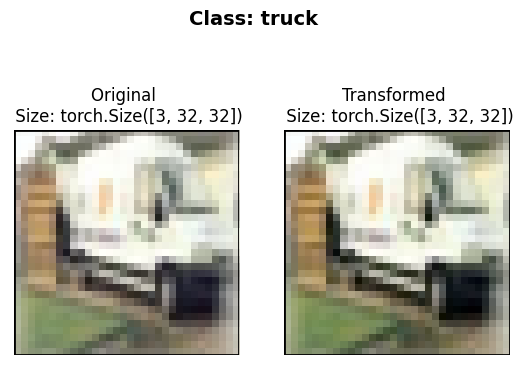

In [ ]:
def min_max_normalization(image: torch.Tensor) -> torch.Tensor:
    """
    Normalize the image using min_max normalization.

    Args:
        image (torch.Tensor): The input image tensor.
    Returns:
        torch.Tensor: The min_max normalized image tensor.
    """
    mins = image.min(dim=1, keepdim=True)[0].min(dim=2, keepdim=True)[0]
    maxs = image.max(dim=1, keepdim=True)[0].max(dim=2, keepdim=True)[0]

    mins_reshaped = mins.expand_as(image)
    maxs_reshaped = maxs.expand_as(image)

    normalized_image = (image - mins_reshaped) / (maxs_reshaped - mins_reshaped)

    return normalized_image

compare_images(cifar10_train, min_max_normalization, cifar10_classes)

###Composition
Finally, we will combine these transformations to be performed **sequentially** in addition to **random horizontal flipping** using [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html) method. <br>
The horizontal flipping is achieved using [`torchvision.transforms.RandomHorizontalFlip()`](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html).

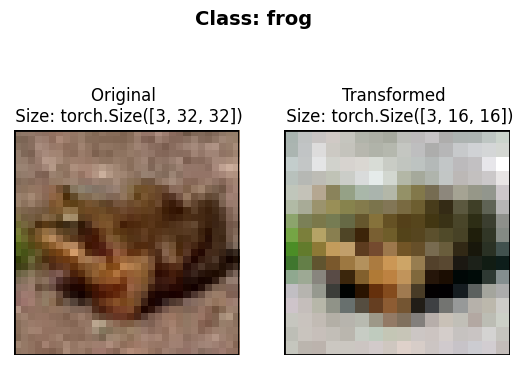

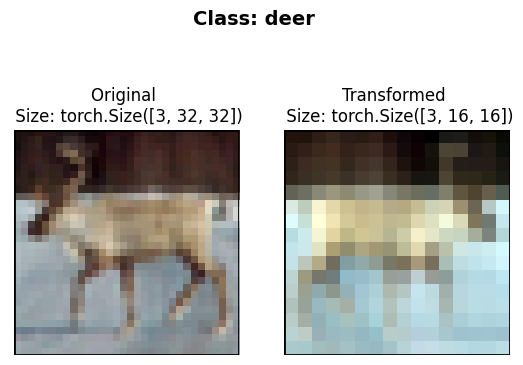

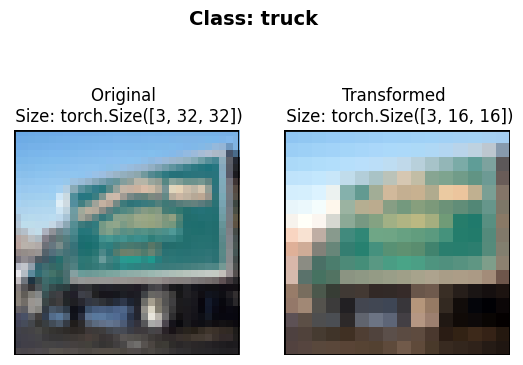

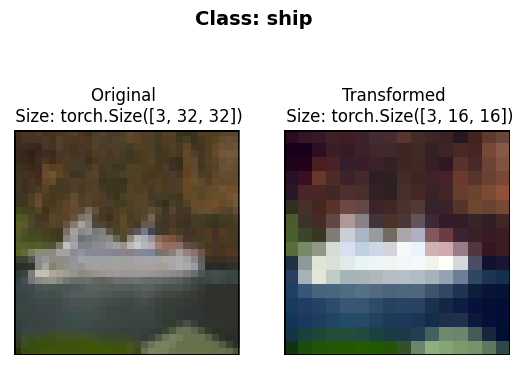

In [ ]:
compose = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.Lambda(min_max_normalization),
    transforms.RandomHorizontalFlip()
])

compare_images(cifar10_train, compose, cifar10_classes)

### `TrivialAugment` for Data Augmentation
[`torchvision.transforms` documentation](https://pytorch.org/vision/stable/transforms.html).

**Data augmentation** is the process of altering your data in such a way that you *artificiallly* increase the diversity of your training set.

Training a model on this *artificially* altered dataset (hopefully) results in a model that is capable of better *generalization*.

Machine Learning is all about harnessing the power of randomness and research shows that random transforms like [`transforms.TrivialAugmentWide()`](https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html) generally perform better than hand-picked transforms. (*[original paper](https://arxiv.org/abs/2103.10158)*).

The idea behind this approach is to **randomly** pick transforms from a set of pre-existing ones and apply them on an image at **random** orders of magnitudes.

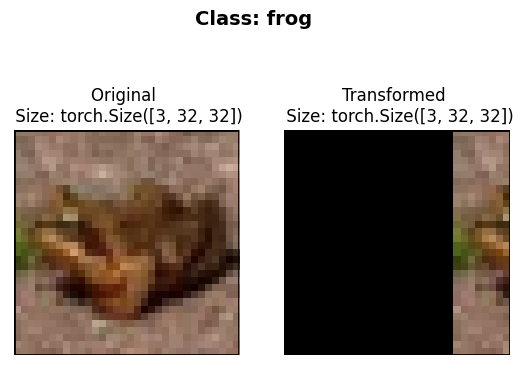

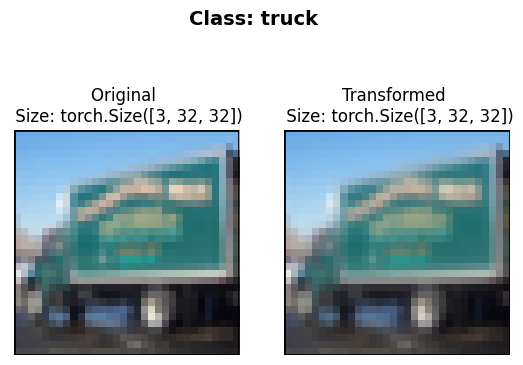

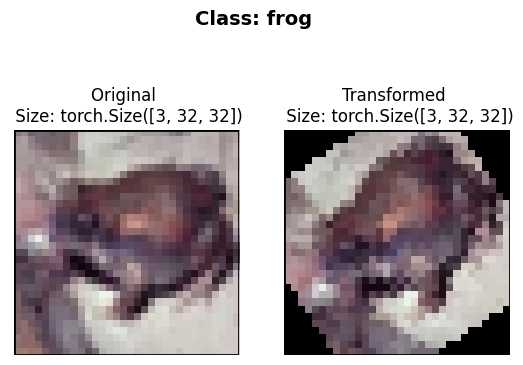

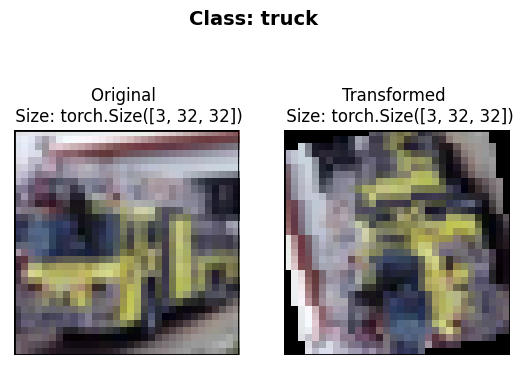

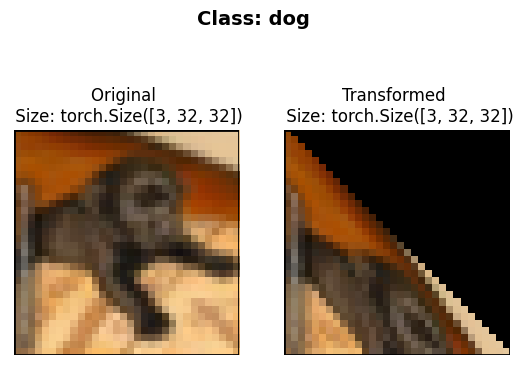

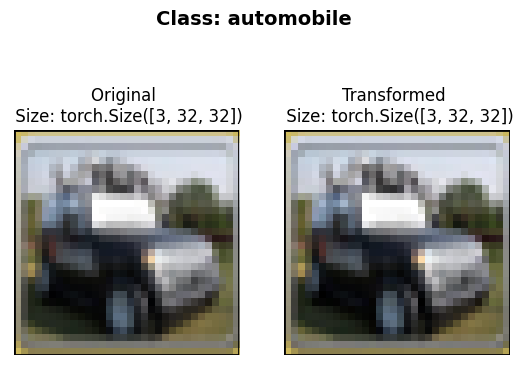

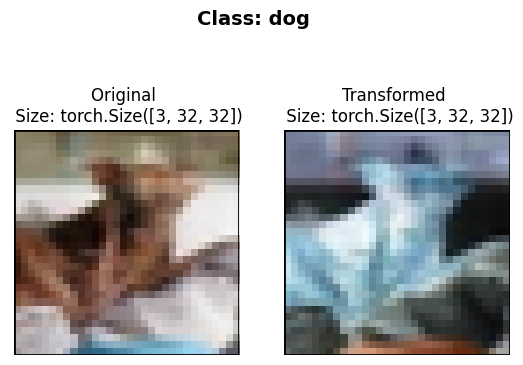

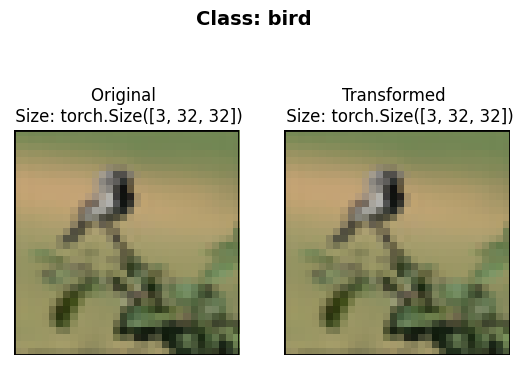

In [ ]:
trivial_augmentation = transforms.TrivialAugmentWide(num_magnitude_bins=5)

compare_images(cifar10_train, trivial_augmentation, cifar10_classes, n=8)

# Custom Dataset
So far, we have been using pre-defined datasets present in `torchvision.datasets` library.

What if we want to load a custom dataset to train and validate our Deep Learning model? This can be achieved by using the `torch.utils.data` library.

In this section we are going to setup our *custom dataset* using a 'trimmed' version of the [**Caltech-101**](https://data.caltech.edu/records/mzrjq-6wc02) dataset.

**Summary**:
- The **Caltech-101 dataset** is a collection of images used for object recognition research.
- It contains **pictures of objects** belonging to **101 different categories**, along with a background category.
- Each category has between **40 to 800 images**, with most categories having around **50 images**.
- The images are of medium resolution, roughly **300 x 200 pixels**.

To keep things simple, we will be using **5 classes**, and **~50 images** per classes.

## Get data

The following code will download the 'trimmed' caltech101_5_classes data from GitHub

In [ ]:
image_path = download_caltech_data()

data/caltech101_5_classes directory exists.


You can see the example storage formate below:

```
caltech101_5_classes/ <- overall dataset folder
        accordion/ <- class name as folder name
            image_0001.jpeg
            image_0002.jpeg
            ...
        ant/
            image_0001.jpeg
            image_0002.jpeg
            ...
        chair/
            image_0001.jpeg
            image_0002.jpg
            ...
        elephant/
            image_0001.jpg
            image_0002.jpg
            ...
        sunflower/
            image_0001.jpg
            image_0002.jpg
            ...
```

The goal will be to take this data storage structure and turn it into a **dataset usable with PyTorch**.

## Data Preparation


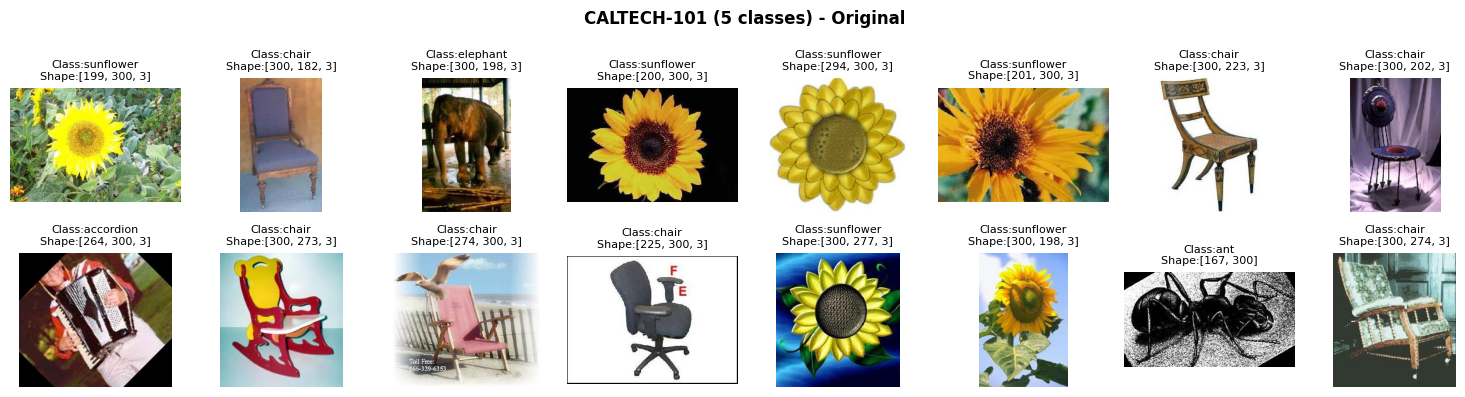

In [ ]:
visualize_caltech_dataset(image_path)

## Data Transformation
As can be observed above, the dataset is **non-uniform** with a mixture of *RGB* and *Grayscale* images. <br>
In this and the upcoming section, we will ensure that we **only** **load uniform sized RGB images** as tensors from the data storage.

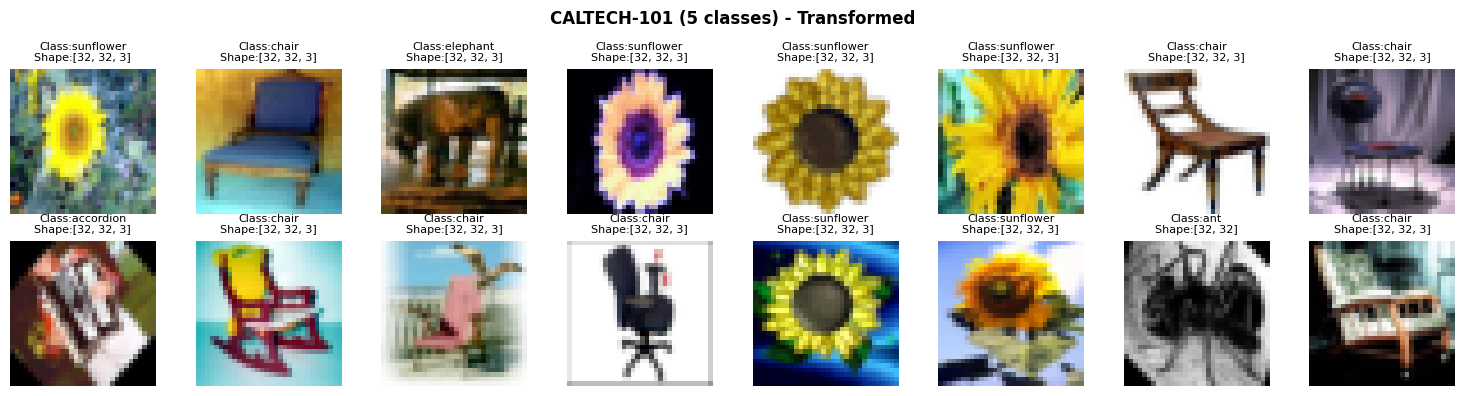

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(min_max_normalization)
])
visualize_caltech_dataset(image_path, transform=data_transform)

## Loading data with Custom `Dataset`
Now that we have a data storage and `data_transform`, we can define a custom dataset inheriting attributes from `torch.utils.Dataset`. <br>
This class will be used as a **default procedure** of *extracting data* from the data storage.

Before we start with defining this procedure, lets define a function to compute the `class_names` and `class_to_idx` dictionary:

In [ ]:
# Make a function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Finds the class folders in a dataset directory and returns the class names and class-to-index mapping.

    Args:
        directory (str): The directory containing the class folders.
    Returns:
        Tuple[List[str], Dict[str, int]]: A tuple containing a list of class names and a dictionary mapping class names to indices.
    """

    classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

    if not classes:
        raise FileNotFoundError(f"No class directories found in {directory}")

    class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

    return classes, class_to_idx

find_classes(image_path)

(['accordion', 'ant', 'chair', 'elephant', 'sunflower'],
 {'accordion': 0, 'ant': 1, 'chair': 2, 'elephant': 3, 'sunflower': 4})

Now, we will define our custom dataset by subclassing `torch.utils.data.Dataset`.

In [ ]:
# 1. Define a class Caltech5(Dataset) that inherits from torch.utils.data.Dataset
class Caltech5(Dataset):
    # 2. Define the __init__ method that initializes the dataset with the target directory and the transformation (optional)
    def __init__(self, targ_dir: str, transform: torchvision.transforms=None) -> None:

        # 3. Create class attributes
        self.paths = sorted(glob.glob(f"{targ_dir}/**/*.jpg", recursive=True))
        self.transform = transform
        self.classes, self.classes_to_idx = find_classes(targ_dir)

    # Function to load images
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self) -> int:

        return len(self.paths)


    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:



        while True:

          img = self.load_image(index)

          if self.transform:
              img = self.transform(img)

          if img.shape[0]!=3:
              index = (index + 1) % len(self.paths)
              img = self.load_image(index)
          else:
            break

        class_name = os.path.basename(os.path.dirname(self.paths[index]))
        class_idx = self.classes_to_idx[class_name]

        return img, class_idx

In [ ]:
caltech_5 = Caltech5(targ_dir=image_path,
                     transform=data_transform)

## 2.5 Data Visualization

Finally, to test out the full potential of our custom dataset, we will call the `visualize()` function defined in the first part for `torchvision.datasets`. If there are no output errors, then it safe to assume that this dataset can be used to train classifier models.

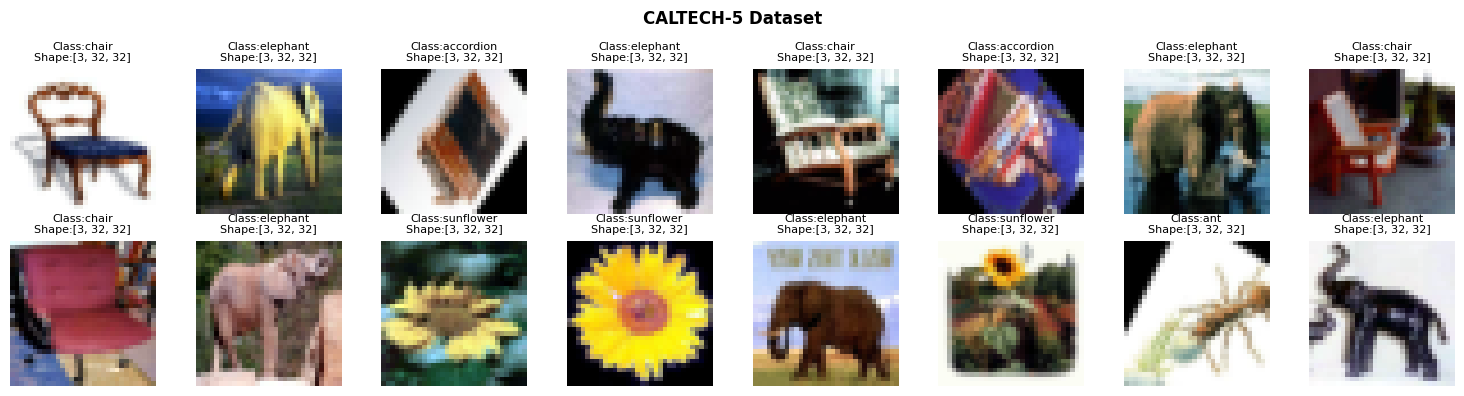

In [ ]:
classes, _= find_classes(image_path)
visualize(caltech_5, "CALTECH-5 Dataset", classes)

# PyTorch `DataLoader`s
`Dataloaders` turn the large `Dataset` into smaller chunks called **batches** or **mini-batches** and can be set by `BATCH_SIZE` parameter. <br>
We perform this operation because it is *computationally efficient* to load *smaller chunks* of data into the model and perform impovements rather than loading all of the data at once.

In this subsection, we are going to create a `Dataloader` for the `caltech_5`
 [link text](https://)dataset.

In [ ]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
## ------------------------Your code ends here----------------------------------##

# ----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
# Lets check what we have created
print(f"Length of dataloader: {len(dataloader)} batches of size {BATCH_SIZE}")
# Check out what's inside the dataloader
features_batch, labels_batch = next(iter(dataloader))
print(f"Batch features shape: {features_batch.shape}, Batch labels shape: {labels_batch.shape}")

Length of dataloader: 1563 batches of size 32
Batch features shape: torch.Size([32, 3, 32, 32]), Batch labels shape: torch.Size([32])
